# Projekt Modelu wykrywającego anomalie w sygnałach EKG
***
Link do datasetu: *https://www.kaggle.com/datasets/shayanfazeli/heartbeat*

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Path to dataset files: /Users/mikolaj/.cache/kagglehub/datasets/shayanfazeli/heartbeat/versions/1


In [2]:
import os

# Wyświetl zawartość folderu
dataset_dir = path
print(os.listdir(dataset_dir))

['mitbih_test.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_train.csv']


In [3]:
import pandas as pd

# Wczytaj dane treningowe
train_data = pd.read_csv(os.path.join(path, "mitbih_train.csv"))
print(train_data.head())

   9.779411554336547852e-01  9.264705777168273926e-01  \
0                  0.960114                  0.863248   
1                  1.000000                  0.659459   
2                  0.925414                  0.665746   
3                  0.967136                  1.000000   
4                  0.927461                  1.000000   

   6.813725233078002930e-01  2.450980395078659058e-01  \
0                  0.461538                  0.196581   
1                  0.186486                  0.070270   
2                  0.541436                  0.276243   
3                  0.830986                  0.586854   
4                  0.626943                  0.193437   

   1.544117629528045654e-01  1.911764740943908691e-01  \
0                  0.094017                  0.125356   
1                  0.070270                  0.059459   
2                  0.196133                  0.077348   
3                  0.356808                  0.248826   
4                  0.094991  

In [4]:
print(train_data.info())
print(train_data.iloc[:, -1].value_counts())  # Rozkład klas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87553 entries, 0 to 87552
Columns: 188 entries, 9.779411554336547852e-01 to 0.000000000000000000e+00.88
dtypes: float64(188)
memory usage: 125.6 MB
None
0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


### Wyświetlanie sygnałów

Ostatnia kolumna w wierszu to etykieta wskazująca klasę (0 = normalny rytm, 1–4 = różne rodzaje arytmii).

> signal = train_data.iloc[0, :-1]
>> 0 - wybiera wiersz
>> :-1 - wszystkie kolumny z wyjątkiem ostatniej (klasa)


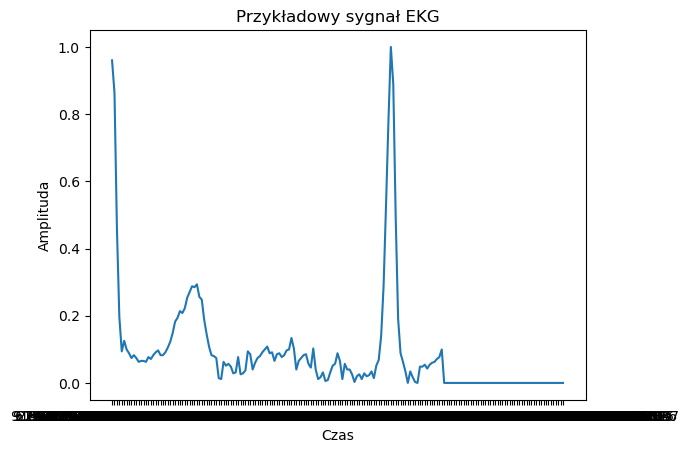

In [5]:
import matplotlib.pyplot as plt

# Przykład: Wizualizacja pierwszego sygnału EKG
signal = train_data.iloc[0, :-1]  # Pobierz sygnał (bez etykiety)
plt.plot(signal)
plt.title("Przykładowy sygnał EKG")
plt.xlabel("Czas")
plt.ylabel("Amplituda")
plt.show()